## 第20章 keras实现风格迁移
风格迁移（style transfer）最近几年非常火，是深度学习领域很有创意的研究成果之一。它主要是通过神经网络，将一幅艺术风格画（style image）和一张普通的照片（content image）巧妙地融合，使一张图片保持本身内容大致不变的情况下呈现出另外一张图片的风格。

### 20.5 实例：Kreras实现风格迁移
有关风格迁移的原理、架构请参考书中对应章节
#### 20.5.1 加载数据

In [21]:
#导入模块
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time

from keras.applications import vgg19
from keras import backend as K

import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, save_img, img_to_array

#定义内容图像与风格图像路径
base_image_path = os.path.join("./data/", "content.jpg")
style_reference_image_path = os.path.join("./data/", "starry_night.jpg")

result_prefix = 'result_'

total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

iterations = 10


#载入图像，并获取内容图像的大小，产生的结果图像应与内容图像一致
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


#### 20.5.2 查看图像

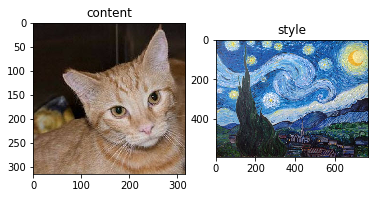

In [5]:
#查看图像内容
plt.subplot(121)
plt.title("content")
plt.imshow(load_img(base_image_path))

plt.subplot(122)
plt.title("style")
plt.imshow(load_img(style_reference_image_path))

plt.show()

#### 20.5.3 预处理数据
接下来，我们定义图像的预处理和再处理函数，它们将图片的三维表示形式（RGB）转换成预训练好的VGG-19网络适合的四维输入形式。

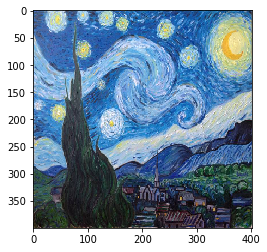

In [7]:
#导入所需模块
import numpy as np
from keras import backend as K
from keras.applications import vgg19#本例中使用vgg19模型

#定义预处理函数，用来读取图像并调整为vgg网络需要的输入格式
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

#定义在处理函数，它与预处理函数是互逆的，即经过预处理的图像被再处理后，将返回原始图像。
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#简单测试两个函数的互逆性
plt.imshow(deprocess_image(preprocess_image(style_reference_image_path)))
plt.show()


#### 20.5.4定义损失函数
接下来，我们需要定义损失函数的各个部分，即内容损失(content loss)、风格损失(style loss)和整体波动损失(total variation loss)。

In [11]:
#定义损失函数以及损失函数
#计算Gram Matrix, 其中，x为某个卷积层的输出矩阵
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
        gram = K.dot(features, K.transpose(features))
    return gram

#风格损失，其中gram_matrix是各个特征图的相关性度量，在20.4节将详细介绍
def style_loss(style, combination):
    #输入参数style为风格图像，combination为生成图像
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

#内容损失，其中base为输入图像，combination为生成图像
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

#整体波动损失，避免生成图像的像素点“跳跃”
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

我们还需要读取内容图像和风格图像，并与生成图像合并组成VGG19的输入矩阵

In [12]:
#读取并预处理内容图像和风格图像
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# 使用placeholder定义生成图像
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# 把内容图像C,风格图像C以及生成图像G连接，组成VGG19模型的输入矩阵
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [13]:
#载入VGG19模型，其输入矩阵即是我们构造的input_tensor,包含了3个图像矩阵
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 4705s 59us/step


In [17]:
#提取各个神经层
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

#总体损失函数是三个损失部分的加权和
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

loss = K.variable(0.0)

#首先计算内容损失
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss =loss+ content_weight * content_loss(base_image_features, combination_features)
#定义在那些卷积层上提取风格特征，分别计算风格损失
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss+ (style_weight / len(feature_layers)) * sl

#添加整体波动损失以保证生成图像的平滑性
loss = loss +total_variation_weight * total_variation_loss(combination_image)

#计算损失函数对于生成图像的梯度
grads = K.gradients(loss, combination_image)

In [22]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

#计算损失与梯度，使用如下定义的Evaluator形式
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

#针对损失与梯度，对生成图像优化，使得生成图像最小化损失函数后即是风格迁移的最终生成图像
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 3592500200.0
Image saved as result__at_iteration_0.png
Start of iteration 1
Current loss value: 2318656000.0
Image saved as result__at_iteration_1.png
Start of iteration 2
Current loss value: 1786919600.0
Image saved as result__at_iteration_2.png
Start of iteration 3
Current loss value: 1552200600.0
Image saved as result__at_iteration_3.png
Start of iteration 4
Current loss value: 1399530000.0
Image saved as result__at_iteration_4.png
Start of iteration 5
Current loss value: 1267422500.0
Image saved as result__at_iteration_5.png
Start of iteration 6
Current loss value: 1182784800.0
Image saved as result__at_iteration_6.png
Start of iteration 7
Current loss value: 1116408800.0
Image saved as result__at_iteration_7.png
Start of iteration 8
Current loss value: 1054875650.0
Image saved as result__at_iteration_8.png
Start of iteration 9
Current loss value: 1011345150.0
Image saved as result__at_iteration_9.png
Iteration 9 completed in 13s


In [34]:
from PIL import Image
%matplotlib inline

img=Image.open('result__at_iteration_0.png','r')
img.show()

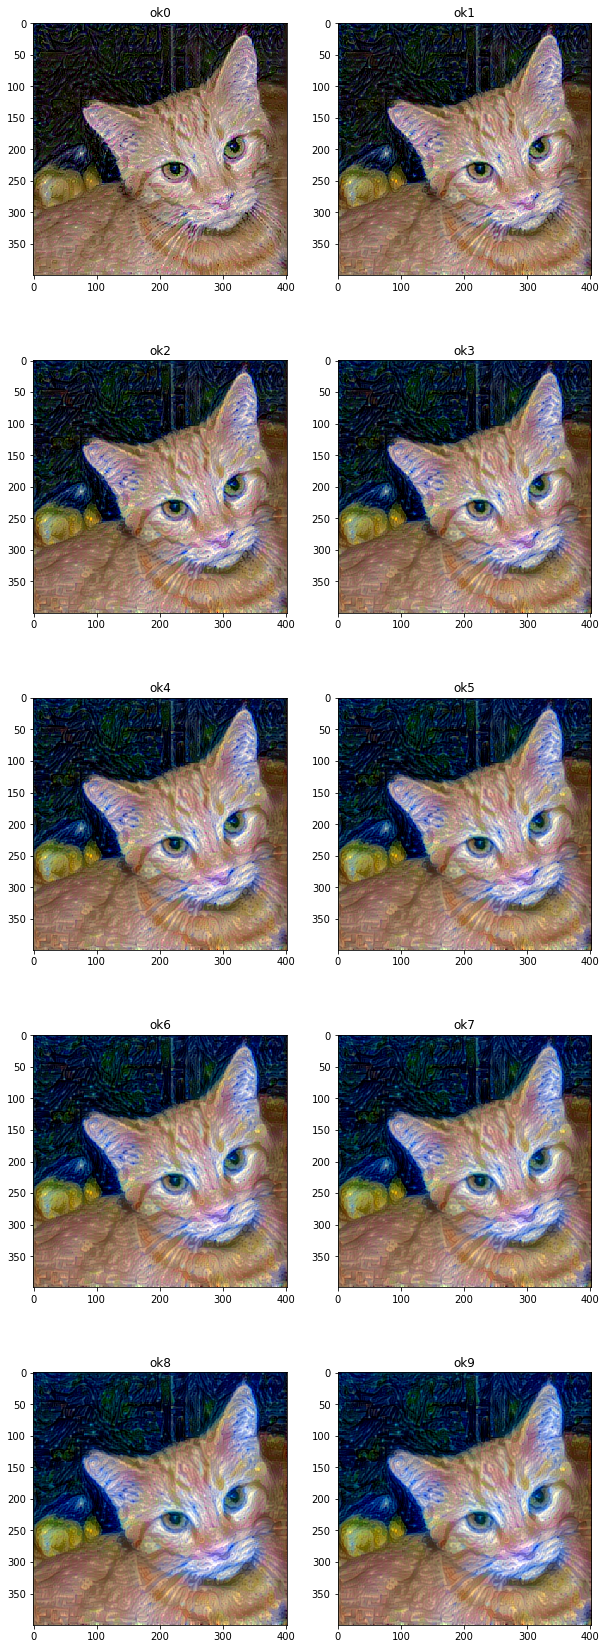

In [69]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 30)) 
for i in range(0,10):
    plt.subplot(5,2,i+1)
    plt.title("ok"+str(i))
    img=Image.open('result__at_iteration_'+str(i)+'.png')
    plt.imshow(img)
plt.show()